In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imripy.halo
import time

## Compare the analytic mass function of the halo profiles with the numeric integration

In [2]:
def CompareMassFunction(halo, r_grid, ax):
    tic = time.perf_counter()
    m_ana = halo.mass(r_grid)  # Here we call the analytic expression
    toc = time.perf_counter()
    t_ana = toc - tic

    tic = time.perf_counter()
    m_num = imripy.halo.MatterHalo.mass(halo, r_grid) # Here we call the numerical odeint integration in the base class
    #m_num = [imripy.halo.MatterHalo.mass(halo, r) for r in r_grid]  # Here we call the numerical quad integration in the base class
    toc = time.perf_counter()
    t_num = toc - tic

    print("Comparing implementation for " + str(halo))
    print("elapsed time in analytic case: ", t_ana)
    print("elapsed time in numeric case:", t_num)
    print("The average relative error is ", np.average(np.abs(m_num/m_ana - 1.)))
    print("The maximal relative error is ", np.max(np.abs(m_num/m_ana - 1.)))

    l, = ax.loglog(r_grid, m_ana, alpha=0.5, label=str(halo) + ',analytic')
    ax.loglog(r_grid, m_num, color=l.get_c(), linestyle='--', label=str(halo) + ',numeric')

Comparing implementation for ConstHalo
elapsed time in analytic case:  3.923499753000215e-05
elapsed time in numeric case: 0.0004342909996921662
The average relative error is  6.97310210712958e-05
The maximal relative error is  0.002349271631419625
Comparing implementation for NFW
elapsed time in analytic case:  0.00019103900194750167
elapsed time in numeric case: 0.001600993000465678
The average relative error is  0.0003647832561301794
The maximal relative error is  0.0364505736878995
Comparing implementation for SpikedNFW
elapsed time in analytic case:  0.0009312170004704967
elapsed time in numeric case: 0.005760194999311352
The average relative error is  6.28110072138366e-08
The maximal relative error is  2.5376234678020637e-06
Comparing implementation for Spike
elapsed time in analytic case:  0.00010557099813013338
elapsed time in numeric case: 0.0018977949985128362
The average relative error is  0.00024885251434264333
The maximal relative error is  0.0020895749139738795
Comparing 

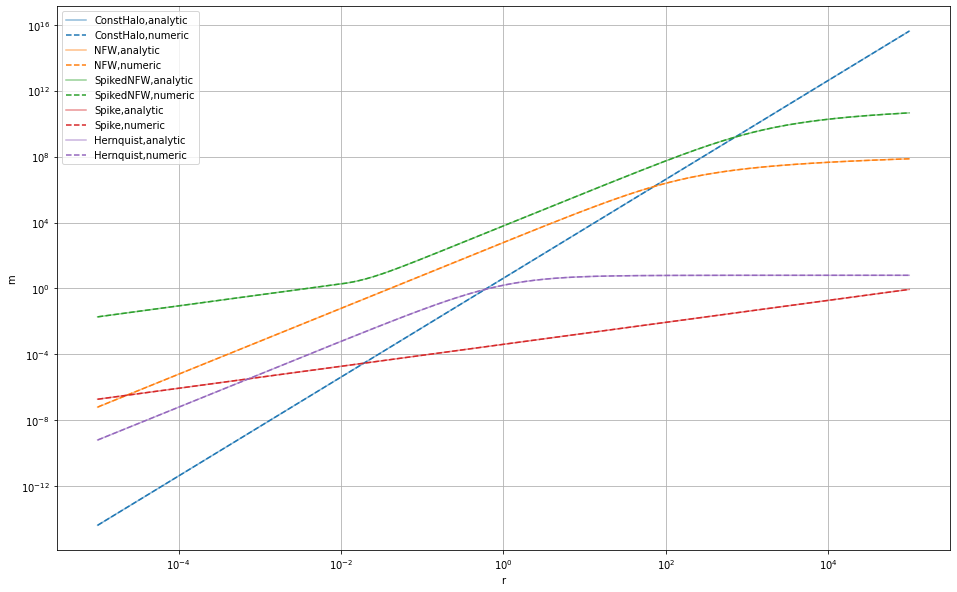

In [3]:
n = 1000
r_grid = np.geomspace(1e-5, 1e5, n)

# Test numerical and analytical mass functions
plt.figure(figsize=(16, 10)); ax = plt.gca()
CompareMassFunction(imripy.halo.ConstHalo(1.), r_grid, ax)
CompareMassFunction(imripy.halo.NFW(1., 1e2), r_grid, ax)
CompareMassFunction(imripy.halo.SpikedNFW(1., 1e3, 1e-2, 7./3.), r_grid, ax)
CompareMassFunction(imripy.halo.Spike(1., 1e-2, 7./3.), r_grid, ax)
CompareMassFunction(imripy.halo.Hernquist(1., 1e0), r_grid, ax)
ax.set_xlabel("r")
ax.set_ylabel("m")
plt.grid(); plt.legend();
plt.show()

## Compare the results from the Eddington inversion procedure with the analytic equations

In [4]:
from scipy.integrate import quad, odeint
from scipy.interpolate import interp1d

In [5]:
def TestEddingtonInversion(halo, r_grid, ax_r, ax_eps, extPotential=None, f_ana=None, pot_ana=None):
    if extPotential is None:  # Invert density function in its own potential
        integrand = lambda r, m: halo.mass(np.abs(r))/r**2
        Phi_inf = quad(integrand, r_grid[-1], np.inf, args=(0.), limit=200)[0]
        Phi_inf = np.clip(Phi_inf, 1e-50, None)
        extPotential =  odeint(integrand, Phi_inf, -r_grid[::-1], tfirst=True, atol=1e-10, rtol=1e-10)[::-1,0]
        extPotential = interp1d(r_grid, extPotential, kind='cubic', bounds_error=False, fill_value=(0.,0.))

    if not pot_ana is None:
        l, = ax_r.loglog(r_grid, extPotential(r_grid), linestyle='--', label=str(halo) + ' $\Phi$, recovered')
        ax_r.loglog(r_grid, pot_ana(r_grid), color=l.get_c(), alpha=0.5, label=str(halo) + ' $\Phi$, analytic')

    Eps_grid = np.geomspace(extPotential(r_grid[-1]), extPotential(r_grid[0]), 500)
    haloRec = imripy.halo.DynamicSS.FromStatic(Eps_grid, halo, extPotential)   # Here the Eddington inversion is called
    
    l, = ax_r.loglog(r_grid, halo.density(r_grid), alpha=0.5, label=str(halo) + ',static')  # Plot for comparison
    ax_r.loglog(r_grid, haloRec.density(r_grid), color=l.get_c(), linestyle='--', label=str(halo) + ',recovered')
    ax_eps.loglog(Eps_grid, haloRec.f_grid, color=l.get_c(), linestyle='--', label=str(halo) +',recovered')
    if not f_ana is None:
        ax_eps.loglog(Eps_grid, f_ana(Eps_grid), color=l.get_c(), alpha = 0.5 , label=str(halo) + ',analytic')
    return haloRec

/media/data/Documents/PhD/DM-density-spikes-GWs-BH-shadows/src/imripy/halo.py:676: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  f_grid = 1./np.sqrt(8.)/np.pi**2 * np.array([ quad(lambda p: d2rho_dphi2(p) / np.sqrt(E - p), 0., E, limit=200)[0] for E in Eps_grid])


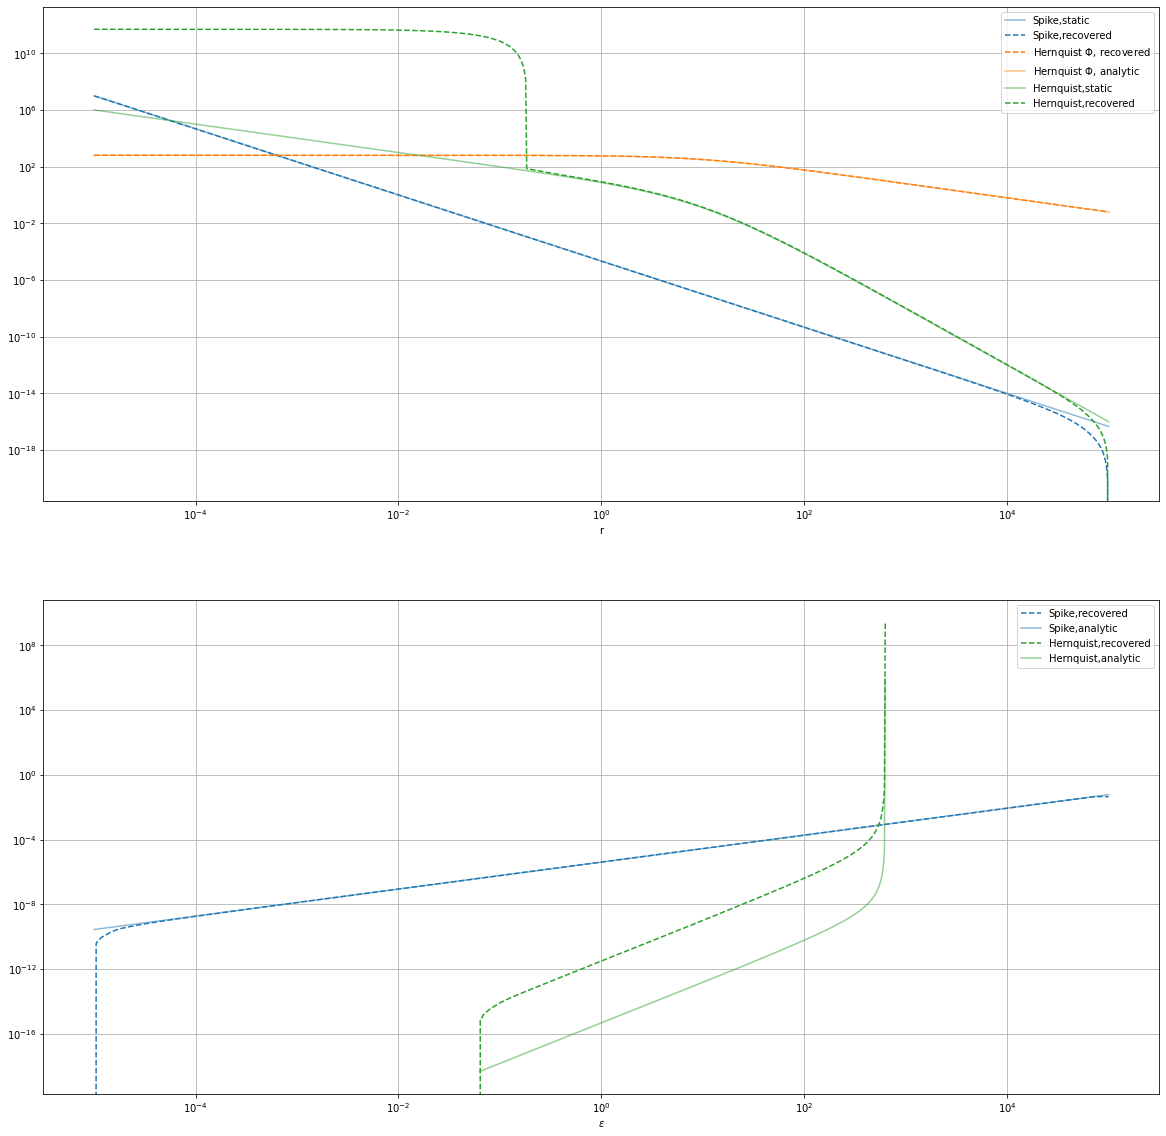

In [9]:
fig, (ax_r, ax_eps) = plt.subplots(2, 1, figsize=(20,20));
n = 1000
r_grid = np.geomspace(1e-5, 1e5, n)

# Test Eddington inversion for Spike profile with known analytic equations
Spike = imripy.halo.Spike(1., 1e-2, 7./3.)
extPotential = lambda r : 1./r
from scipy.special import gamma
f_ana = lambda E : Spike.rho_spike * Spike.alpha*(Spike.alpha-1.)/(2.*np.pi)**(3./2.) * (Spike.r_spike/1.)**Spike.alpha * gamma(Spike.alpha-1.)/gamma(Spike.alpha-1./2.) * E**(Spike.alpha-3./2.)
TestEddingtonInversion( Spike , r_grid, ax_r, ax_eps, extPotential, f_ana)

# Test Eddington inversion for Hernquist profile with known analytic equations
Hern = imripy.halo.Hernquist(1., 1e1)
def f_ana_Hern(Eps):
    M = 2.*np.pi * Hern.rho_s * Hern.r_s**3
    E = Eps*Hern.r_s/M
    return (M * Hern.r_s)**(-3./2.)/np.sqrt(2)/(2.*np.pi)**3 * np.sqrt(E)/(1-E)**2  *( (1.-2*E)*(8.*E**2 - 8.*E - 3.) + 3.*np.arcsin(np.sqrt(E)) / np.sqrt(E*(1-E))  )
def pot_ana_Hern(r):
    M = 2.*np.pi * Hern.rho_s * Hern.r_s**3
    return M/(r + Hern.r_s)

TestEddingtonInversion( Hern , r_grid, ax_r, ax_eps, extPotential=None, f_ana=f_ana_Hern, pot_ana=pot_ana_Hern)

ax_eps.grid(); ax_eps.legend(); ax_eps.set_xlabel(r"$\varepsilon$"); ax
ax_r.grid(); ax_r.legend(); ax_r.set_xlabel("r")
plt.show()